In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics, linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Data Inspection

In this section, we are going to inspect the quality of data we have and talk about approach we are going to take

## Read Data

We are going to classify on tweets of five different languages: Arabic, Danish, Greek, Turkish, and English. Here we are going to read them and study the basic information of our data.

In [3]:
def read_file(filename):
    global file,labels
    file = pd.read_csv(filename, sep='\t')
    file['class'] = file['subtask_a'].factorize()[0]
    x_train = file['tweet'].to_list()
    y_train = [x for x in file['class']]
    return file


### Arabic

In [4]:
train_ar = read_file('offenseval-ar-training-v1.tsv')
#eng = read_file('task_a_distant.tsv')

In [5]:
test_ar=read_file('offenseval-ar-dev-v1.tsv')

In [6]:
#Data is unbalaced
train_ar.groupby('class').tweet.count()

class
0    5468
1    1371
Name: tweet, dtype: int64

In [7]:
test_ar.groupby('class').tweet.count()

class
0    821
1    179
Name: tweet, dtype: int64

### Danish

In [8]:
da=read_file('offenseval-da-training-v1.tsv')

In [9]:
da.groupby('class').tweet.count()

class
-1       0
 0    2576
 1     384
Name: tweet, dtype: int64

### Greek

gr = read_file('offenseval-greek-training-v1.tsv')

In [10]:
gr = read_file('offenseval-greek-training-v1.tsv')

In [11]:
gr.head()

,id,tweet,subtask_a,class
0,1172,@USER Οι μουσουλμάνες που τις βιάζουν έτσι κ α...,OFF,0
1,4078,Η Κάτια προσπαθεί να πείσει οτι δεν είναι ελέφ...,NOT,1
2,135,"Καλά γιατί λες ότι, είσαι νέος αφού γεννήθηκες...",NOT,1
3,9056,Με Φατσεα ξεκινησαμε...... #Kokkinopotami,NOT,1
4,5344,"#gntmgr Κάτια πόσο γλυκιά, εμετός",NOT,1


In [12]:
#Since in gr 0 is OFF and 1 is NOT, which does not correspond to other datasets, we swap the value
gr=gr.replace([0, 1,], [1, 0])

In [13]:
gr.groupby('class').tweet.count()

class
0    6257
1    2486
Name: tweet, dtype: int64

### Turkish

In [14]:
tr = read_file('offenseval-tr-training-v1.tsv')

In [15]:
tr.groupby('class').tweet.count()

class
0    25231
1     6046
Name: tweet, dtype: int64

### English

In [16]:
engfile = pd.read_csv('task_a_distant.tsv', sep='\t')

In [17]:
engfile['average'].values[engfile['average'].values>0.5]=1
engfile['average'].values[engfile['average'].values<=0.5]=0

In [18]:
engfile['tweet'] = engfile['text']
engfile['class'] = engfile['average']

In [19]:
engfile.groupby('class').tweet.count()

class
0.0    7628650
1.0    1446768
Name: tweet, dtype: int64

In [20]:
eng = engfile.sample(n = 50000)

In [21]:
eng.groupby('class').tweet.count()

class
0.0    42064
1.0     7936
Name: tweet, dtype: int64

In [22]:
def clean_text(s):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U0001F1F2-\U0001F1F4"  
        u"\U0001F1E6-\U0001F1FF"  
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    c = emoji_pattern.sub(r'',s)
    #c = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',c)
    c = c.lower()
    #c = re.sub('[^\w\s]+',' ', c)
    c = re.sub(r'[0-9]+','',c)
    #c = c.split()
       
    return c



## Imbalanced data

Since we already observed that we have imbalanced data, we want to use visualization to understand it.

In [23]:
barwidth = 0.25
bar0 = [5468,2576,6257,25231]
bar1 = [1371,384,2486,6046]

#position for bar
r1 = np.arange(len(bar0))
r2 = [x + barwidth for x in r1]
#r3 = [x + barwidth for x in r2]
#r4 = [x + barwidth for x in r3]

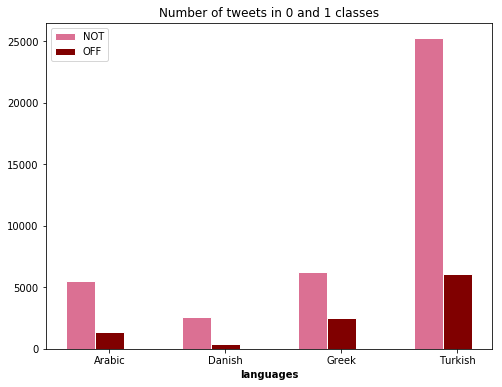

In [24]:
fig = plt.figure(figsize=(8,6))
plt.bar(r1, bar0, color='palevioletred', width=barwidth, edgecolor='white', label='NOT')
plt.bar(r2, bar1, color='maroon', width=barwidth, edgecolor='white', label='OFF')
plt.xlabel('languages', fontweight='bold')
plt.xticks([r + barwidth for r in range(len(bar1))], ['Arabic', 'Danish', 'Greek', 'Turkish'])
plt.title('Number of tweets in 0 and 1 classes')
plt.legend()
plt.show()
fig.savefig('EDA_boxplot.jpeg')

The number of tweets of two classes are imbalanced. There are more non-offensive tweets than offensive tweets. Also, we can observe that the percentage of offensive tweets are extremely lwo in Danish. We need to consider down-sampling or up-sampling in our analysis

## Missing Value

In [27]:
train_ar.isnull().values.any()

False

In [28]:
test_ar.isnull().values.any()

False

In [29]:
da.isnull().values.any()

True

In [30]:
gr.isnull().values.any()

False

In [31]:
tr.isnull().values.any()

False

In [32]:
#We see that da dataset has null values. We see that only 1 row has null value.
#We choose to filter out that row for convinience
da.isnull().sum()

id           0
tweet        1
subtask_a    1
class        0
dtype: int64

In [33]:
da=da.dropna()

# Data Engineering

In this part we are going to arrange our dataset into a format ready for classfication

## Create a function using Arabic Dataset

Since all the dataset we are given having the identical columns and format, we want to use one of the dataset to create a standard function which we can apply to other dataset

In [25]:
ar=train_ar.append(test_ar)

In [26]:
#Since nltk has the stopwords list for all languages we are working on here, we can create a comprehensive
#stopwords list
from nltk.corpus import stopwords
stopwords_list = stopwords.words('arabic') + stopwords.words('danish') \
    +stopwords.words('greek') + stopwords.words('turkish') + stopwords.words('english')

In [27]:
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                             ngram_range=(1, 2), stop_words= stopwords_list)

In [28]:
x = ar['tweet'].to_list()
y = [x for x in ar['class']]

In [29]:
#tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(ar['tweet'])
x_tfidf =  tfidf_vect.transform(x)

/Users/zhijuncai/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['δι', 'ἀλλ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [30]:
#We can see that we have a 
x_tfidf

<7839x4023 sparse matrix of type '<class 'numpy.float64'>'
	with 70292 stored elements in Compressed Sparse Row format>

In [31]:
def get_data(dataset):
    x = dataset.iloc[:,:-1]
    y = [x for x in dataset['class']]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    tfidf_vect.fit(X_train['tweet'])
    X_train=X_train['tweet'].to_list()
    X_test=X_test['tweet'].to_list()
    x_tfidf_train =  tfidf_vect.transform(X_train)
    x_tfidf_test =  tfidf_vect.transform(X_test)
    return x_tfidf_train, x_tfidf_test, y_train, y_test

In [32]:
a,b,c,d=get_data(ar)

In [33]:
a

<5252x2456 sparse matrix of type '<class 'numpy.float64'>'
	with 41630 stored elements in Compressed Sparse Row format>

## Get dataset for classification

Now we can simply use the function we created to get dataframe we need for modeling

In [34]:
from sklearn.utils import resample

In [35]:
x = ar.iloc[:,:-1]
y = [x for x in ar['class']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [36]:
X_train['class']=y_train

/Users/zhijuncai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
data=X_train

In [38]:
df_majority = data[data['class']==0]
df_minority = data[data['class']==1]

In [39]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results

In [40]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [41]:
x = df_downsampled['tweet'].to_list()
y = [x for x in df_downsampled['class']]

In [42]:
len(y)

2044

In [43]:
tfidf_vect.fit(X_train['tweet'])

TfidfVectorizer(encoding='latin-1', min_df=5, ngram_range=(1, 2),
                stop_words=['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر',
                            'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي',
                            'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان',
                            'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم',
                            'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', ...],
                sublinear_tf=True)

In [44]:
def get_data_downsample(dataset):
    x = dataset.iloc[:,:-1]
    y = [x for x in dataset['class']]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    X_train['class']=y_train
    data=X_train
    df_majority = data[data['class']==0]
    df_minority = data[data['class']==1]
 
#Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
#Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    x = df_downsampled['tweet'].to_list()
    y = [x for x in df_downsampled['class']]
    tfidf_vect.fit(X_train['tweet'])
    X_test=X_test['tweet'].to_list()
    x_tfidf_train =  tfidf_vect.transform(x)
    x_tfidf_test =  tfidf_vect.transform(X_test)
    return x_tfidf_train, x_tfidf_test, y, y_test

In [45]:
a,b,c,d=get_data_downsample(ar)

/Users/zhijuncai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [46]:
a

<2044x2456 sparse matrix of type '<class 'numpy.float64'>'
	with 16627 stored elements in Compressed Sparse Row format>

In [47]:
len(d)

2587

In [48]:
def get_data_upsample(dataset):
    x = dataset.iloc[:,:-1]
    y = [x for x in dataset['class']]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
    X_train['class']=y_train
    data=X_train
    df_majority = data[data['class']==0]
    df_minority = data[data['class']==1]
 
#Downsample majority class
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
#Combine minority class with downsampled majority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    x = df_upsampled['tweet'].to_list()
    y = [x for x in df_upsampled['class']]
    tfidf_vect.fit(X_train['tweet'])
    X_test=X_test['tweet'].to_list()
    x_tfidf_train =  tfidf_vect.transform(x)
    x_tfidf_test =  tfidf_vect.transform(X_test)
    return x_tfidf_train, x_tfidf_test, y, y_test

In [49]:
a,b,c,d=get_data_upsample(ar)

/Users/zhijuncai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [50]:
len(c)

7590

# Modeling

In [51]:

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb
from matplotlib import pyplot
import warnings

warnings.simplefilter('ignore')

>lr 0.838 (0.033)
>bayes 0.825 (0.032)
>rf 0.788 (0.040)
>xgb 0.761 (0.034)
>lsvc 0.825 (0.030)


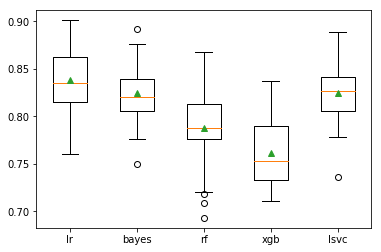

In [61]:

def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['bayes'] = MultinomialNB()
	models['rf'] = RandomForestClassifier()
	models['xgb'] = xgb.XGBClassifier()
	models['lsvc'] = LinearSVC()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    model.fit(X_train,y_train)
    scores = cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=cv, error_score='raise')
    return scores
 
# define dataset
X_train, X_test, y_train, y_test = get_data(ar)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>lr 0.825 (0.012)
>bayes 0.838 (0.012)
>rf 0.839 (0.012)
>xgb 0.828 (0.014)
>lsvc 0.843 (0.014)


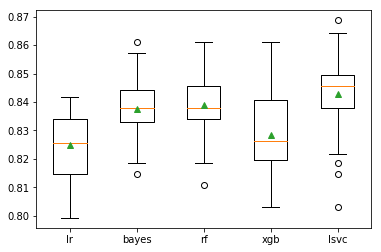

In [62]:
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['bayes'] = MultinomialNB()
	models['rf'] = RandomForestClassifier()
	models['xgb'] = xgb.XGBClassifier()
	models['lsvc'] = LinearSVC()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    model.fit(X_train,y_train)
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, error_score='raise')
    return scores
 
# define dataset
X_train, X_test, y_train, y_test = get_data(ar)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [63]:

from mlxtend.classifier import StackingClassifier

In [64]:
def stacking(dataset):
    X_train, X_test, y_train, y_test=get_data(dataset)
    clf1 = LogisticRegression()
    clf2 = MultinomialNB()
    clf3 = RandomForestClassifier()
    clf4 = xgb.XGBClassifier()
    clf5 = LinearSVC()
    lr = LogisticRegression()
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3,clf4,clf5], 
                          meta_classifier=lr)

    print('3-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3,clf4,clf5, sclf], 
                          ['Logistic', 
                           'Naive Bayes', 
                           'RandomForest',
                           'XGB',
                           'LinearSVC',
                           'StackingClassifier']):
        clf.fit(X_train,y_train)
        scores = cross_val_score(clf, X_test, y_test, scoring='f1_macro', error_score='raise')
        
        print("Marco_F1: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))

In [65]:
stacking(ar)

3-fold cross validation:

Marco_F1: 0.56 (+/- 0.02) [Logistic]
Marco_F1: 0.59 (+/- 0.02) [Naive Bayes]
Marco_F1: 0.65 (+/- 0.01) [RandomForest]
Marco_F1: 0.61 (+/- 0.00) [XGB]
Marco_F1: 0.70 (+/- 0.01) [LinearSVC]
Marco_F1: 0.71 (+/- 0.01) [StackingClassifier]


In [66]:
stacking(da)

3-fold cross validation:

Marco_F1: 0.48 (+/- 0.01) [Logistic]
Marco_F1: 0.49 (+/- 0.02) [Naive Bayes]
Marco_F1: 0.67 (+/- 0.02) [RandomForest]
Marco_F1: 0.63 (+/- 0.02) [XGB]
Marco_F1: 0.67 (+/- 0.04) [LinearSVC]
Marco_F1: 0.66 (+/- 0.03) [StackingClassifier]


In [67]:
stacking(tr)

3-fold cross validation:

Marco_F1: 0.54 (+/- 0.01) [Logistic]
Marco_F1: 0.48 (+/- 0.00) [Naive Bayes]
Marco_F1: 0.62 (+/- 0.01) [RandomForest]
Marco_F1: 0.57 (+/- 0.01) [XGB]
Marco_F1: 0.66 (+/- 0.00) [LinearSVC]
Marco_F1: 0.67 (+/- 0.00) [StackingClassifier]


In [68]:
stacking(gr)

3-fold cross validation:

Marco_F1: 0.62 (+/- 0.02) [Logistic]
Marco_F1: 0.58 (+/- 0.00) [Naive Bayes]
Marco_F1: 0.68 (+/- 0.03) [RandomForest]
Marco_F1: 0.68 (+/- 0.02) [XGB]
Marco_F1: 0.69 (+/- 0.01) [LinearSVC]
Marco_F1: 0.70 (+/- 0.01) [StackingClassifier]


In [69]:
stacking(eng)

3-fold cross validation:

Marco_F1: 0.75 (+/- 0.01) [Logistic]
Marco_F1: 0.59 (+/- 0.01) [Naive Bayes]
Marco_F1: 0.86 (+/- 0.00) [RandomForest]
Marco_F1: 0.79 (+/- 0.01) [XGB]
Marco_F1: 0.86 (+/- 0.00) [LinearSVC]
Marco_F1: 0.88 (+/- 0.01) [StackingClassifier]


In [70]:
def upsampling_stacking(dataset):
    X_train, X_test, y_train, y_test = get_data_upsample(dataset)
    clf1 = LogisticRegression()
    clf2 = MultinomialNB()
    clf3 = RandomForestClassifier()
    clf4 = xgb.XGBClassifier()
    clf5 = LinearSVC()
    lr = RandomForestClassifier()
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3,clf4,clf5], 
                          meta_classifier=lr)

    print('3-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3,clf4,clf5, sclf], 
                          ['Logistic', 
                           'Naive Bayes', 
                           'RandomForest',
                           'XGB',
                           'LinearSVC',
                           'StackingClassifier']):

        clf.fit(X_train,y_train)
        scores = cross_val_score(clf, X_test, y_test, scoring='f1_macro',  error_score='raise')
        print("Marco_F1: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))

In [71]:
upsampling_stacking(ar)

3-fold cross validation:

Marco_F1: 0.60 (+/- 0.02) [Logistic]
Marco_F1: 0.63 (+/- 0.02) [Naive Bayes]
Marco_F1: 0.65 (+/- 0.01) [RandomForest]
Marco_F1: 0.61 (+/- 0.01) [XGB]
Marco_F1: 0.72 (+/- 0.01) [LinearSVC]
Marco_F1: 0.73 (+/- 0.01) [StackingClassifier]


In [72]:
upsampling_stacking(da)

3-fold cross validation:

Marco_F1: 0.48 (+/- 0.01) [Logistic]
Marco_F1: 0.49 (+/- 0.02) [Naive Bayes]
Marco_F1: 0.64 (+/- 0.06) [RandomForest]
Marco_F1: 0.63 (+/- 0.03) [XGB]
Marco_F1: 0.64 (+/- 0.03) [LinearSVC]
Marco_F1: 0.65 (+/- 0.05) [StackingClassifier]


In [73]:
upsampling_stacking(tr)

3-fold cross validation:

Marco_F1: 0.55 (+/- 0.01) [Logistic]
Marco_F1: 0.50 (+/- 0.00) [Naive Bayes]
Marco_F1: 0.62 (+/- 0.00) [RandomForest]
Marco_F1: 0.57 (+/- 0.01) [XGB]
Marco_F1: 0.66 (+/- 0.01) [LinearSVC]
Marco_F1: 0.67 (+/- 0.01) [StackingClassifier]


In [74]:
upsampling_stacking(gr)

3-fold cross validation:

Marco_F1: 0.66 (+/- 0.01) [Logistic]
Marco_F1: 0.61 (+/- 0.01) [Naive Bayes]
Marco_F1: 0.69 (+/- 0.01) [RandomForest]
Marco_F1: 0.67 (+/- 0.01) [XGB]
Marco_F1: 0.71 (+/- 0.01) [LinearSVC]
Marco_F1: 0.71 (+/- 0.01) [StackingClassifier]


In [75]:
upsampling_stacking(eng)

3-fold cross validation:

Marco_F1: 0.77 (+/- 0.01) [Logistic]
Marco_F1: 0.62 (+/- 0.01) [Naive Bayes]
Marco_F1: 0.86 (+/- 0.01) [RandomForest]
Marco_F1: 0.79 (+/- 0.00) [XGB]
Marco_F1: 0.87 (+/- 0.00) [LinearSVC]
Marco_F1: 0.87 (+/- 0.00) [StackingClassifier]


In [76]:
def down_stacking(dataset):
    X_train, X_test, y_train, y_test=get_data_downsample(dataset)
    clf1 = LogisticRegression()
    clf2 = MultinomialNB()
    clf3 = RandomForestClassifier()
    clf4 = xgb.XGBClassifier()
    clf5 = LinearSVC()
    lr = RandomForestClassifier()
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3,clf4,clf5], 
                          meta_classifier=lr)

    print('3-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3,clf4,clf5, sclf], 
                          ['Logistic', 
                           'Naive Bayes', 
                           'RandomForest',
                           'XGB',
                           'LinearSVC',
                           'StackingClassifier']):
        clf.fit(X_train,y_train)
        scores = cross_val_score(clf, X_test, y_test, scoring='f1_macro',  error_score='raise')
        
        print("Marco_F1: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))

In [77]:
down_stacking(ar)

3-fold cross validation:

Marco_F1: 0.56 (+/- 0.02) [Logistic]
Marco_F1: 0.59 (+/- 0.02) [Naive Bayes]
Marco_F1: 0.64 (+/- 0.01) [RandomForest]
Marco_F1: 0.61 (+/- 0.00) [XGB]
Marco_F1: 0.70 (+/- 0.01) [LinearSVC]
Marco_F1: 0.71 (+/- 0.01) [StackingClassifier]


In [78]:
down_stacking(da)

3-fold cross validation:

Marco_F1: 0.48 (+/- 0.01) [Logistic]
Marco_F1: 0.49 (+/- 0.02) [Naive Bayes]
Marco_F1: 0.65 (+/- 0.05) [RandomForest]
Marco_F1: 0.63 (+/- 0.02) [XGB]
Marco_F1: 0.67 (+/- 0.04) [LinearSVC]
Marco_F1: 0.69 (+/- 0.03) [StackingClassifier]


In [79]:
down_stacking(tr)

3-fold cross validation:

Marco_F1: 0.54 (+/- 0.01) [Logistic]
Marco_F1: 0.48 (+/- 0.00) [Naive Bayes]
Marco_F1: 0.62 (+/- 0.01) [RandomForest]
Marco_F1: 0.57 (+/- 0.01) [XGB]
Marco_F1: 0.66 (+/- 0.00) [LinearSVC]
Marco_F1: 0.67 (+/- 0.00) [StackingClassifier]


In [80]:
down_stacking(gr)

3-fold cross validation:

Marco_F1: 0.62 (+/- 0.02) [Logistic]
Marco_F1: 0.58 (+/- 0.00) [Naive Bayes]
Marco_F1: 0.67 (+/- 0.01) [RandomForest]
Marco_F1: 0.68 (+/- 0.02) [XGB]
Marco_F1: 0.69 (+/- 0.01) [LinearSVC]
Marco_F1: 0.70 (+/- 0.01) [StackingClassifier]


In [ ]:
down_stacking(eng)

In [82]:
def stacking_probas(dataset):
    X_train, X_test, y_train, y_test = get_data(dataset)
    clf1 = LogisticRegression()
    clf2 = MultinomialNB()
    clf3 = RandomForestClassifier()
    clf4 = xgb.XGBClassifier()
    lr = RandomForestClassifier()
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3,clf4],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

    print('3-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3,clf4, sclf], 
                          ['Logistic', 
                           'Naive Bayes', 
                           'RandomForest',
                           'XGB',
                           'StackingClassifier']):

        clf.fit(X_train,y_train)
        scores = cross_val_score(clf, X_test, y_test, scoring='f1_macro',  error_score='raise')
        print("F1_marco: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))

In [54]:
stacking_probas(ar)

3-fold cross validation:

F1_marco: 0.56 (+/- 0.02) [Logistic]
F1_marco: 0.59 (+/- 0.02) [Naive Bayes]
F1_marco: 0.64 (+/- 0.03) [RandomForest]
F1_marco: 0.61 (+/- 0.00) [XGB]
F1_marco: 0.70 (+/- 0.01) [StackingClassifier]


In [89]:
from sklearn import model_selection

In [101]:
from sklearn.model_selection import GridSearchCV

In [103]:
clf1 = KNeighborsClassifier()
clf2 = LogisticRegression()
clf3 = DecisionTreeClassifier()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.80 (+/- 0.00) [KNN]
Accuracy: 0.85 (+/- 0.00) [Random Forest]


C:\Games\anaconoda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


Accuracy: 0.82 (+/- 0.00) [Naive Bayes]


C:\Games\anaconoda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Games\anaconoda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Games\anaconoda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Games\anaconoda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Games\anaconoda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Games\anaconoda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

Accuracy: 0.82 (+/- 0.00) [StackingClassifier]


In [52]:
vocab_size = len(a)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [55]:
a.shape[0]

7590

## Draft/Baseline

### Logistic Regression

In [18]:
clf2 = linear_model.LogisticRegression()

In [ ]:
clf2.fit(x_train_tfidf, y_train)

In [20]:
predicted2 = clf2.predict(x_valid_tfidf)

In [21]:
metrics.accuracy_score(predicted2, y_test)

0.878

In [22]:
report = metrics.classification_report(y_test, predicted2,output_dict = True)

In [31]:
print(metrics.classification_report(y_test, predicted2))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       821
           1       0.94      0.34      0.50       179

    accuracy                           0.88      1000
   macro avg       0.91      0.67      0.72      1000
weighted avg       0.89      0.88      0.85      1000



In [25]:
baseline_eva = pd.DataFrame(report).transpose()

In [27]:
baseline_eva.to_csv (r'baseline_report.csv', index = False, header=True)


### Linear Support Vector Classification

In [160]:
clf3 = LinearSVC()

In [161]:
clf3.fit(x_train_tfidf, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [162]:
predicted3 = clf3.predict(x_valid_tfidf)

In [163]:
print(metrics.classification_report(y_test, predicted3))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       821
           1       0.74      0.58      0.65       179

    accuracy                           0.89      1000
   macro avg       0.83      0.77      0.79      1000
weighted avg       0.88      0.89      0.88      1000



In [164]:
metrics.accuracy_score(predicted3, y_test)

0.888

### bert

In [105]:
lst = []
for x in x_train:
    lst.append(clean_text(x))

NameError: name 'x_train' is not defined

In [35]:
lst

['الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم يا رجالة <lf>الدوري يا زمالك .. الدوري يا زمالك<lf>#صدارة_بس',
 'فدوه يا بخت فدوه يا زمن واحد منكم يجيبه',
 'rt @user: يا رب يا واحد يا أحد بحق يوم الاحد ان تهلك بني سعود المجرمين. لاجل اطفال اليمن شاركوا.',
 'rt @user: #هوا_الحرية يا وجع قلبي عليكي يا امي...<lf>الله لا يحرق قلبك ويكسر بخاطرك للمرة الف نقف إجلال لعظمة وقدرة لين قلب الأم ال…',
 'يا بكون بحياتك الأهم يا إما ما بدي أكون ',
 '@user اخخ يا قلببي يا هالحلقه  متعه على بكاء على حماس كل المشاعر داخله ببعض',
 'والله الزول السوداني أثبت أنه سابق بالتحضّر عن كل العرب:<lf>٤٠٪ التمثيل النسائي في المجلس التشريعي السوداني ما بعد الثورة. <lf>الكلام إلك يا جارة لتسمعي يا كنّة!<lf>#السودان #سوريا #الجزائر',
 'rt @user: جالس أسمع أحمد قاسم يغني: "أحبك من كل قلبي يا بلادي يا يمن". حتى أنا والله أحب اليمن من كل قلبي أحب بلادي من طرفها لطرفها "ب…',
 'في قلبي يا مغلاك<lf>وبعيني يا محلاك ..',
 'يا التاج ع الراس يا السادة<lf>يا مالك الروح وراعيها',
 'rt @user: @user البراب عندى بيقولى بيخيروك يا 

In [71]:
from bert_serving.client import BertClient

In [72]:
# make a connection with the BERT server using it's ip address; do not give any ip if same computer
bc = BertClient()
# get the embedding
embedding = bc.encode(lst)
# check the shape of embedding, it should be 1x768
print(embedding.shape)

NameError: name 'lst' is not defined

In [38]:
dev = bc.encode(x_test)
print(dev.shape)

(1000, 768)


In [41]:
from sklearn.linear_model import LogisticRegression
model_bert = LogisticRegression()
# train
model_bert = model_bert.fit(embedding, y_train)
# predict
pred_bert = model_bert.predict(dev)

/Users/zhijuncai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
from sklearn.metrics import accuracy_score
print(metrics.classification_report(y_test, pred_bert))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       821
           1       0.53      0.28      0.37       179

    accuracy                           0.83      1000
   macro avg       0.69      0.62      0.64      1000
weighted avg       0.80      0.83      0.81      1000

